# NBA Predictions Model Testing and Evaluation 

## Background

Basketball, and the professional league run by the NBA, is the second most popular sport in the United States. According to Forbes, regular season NBA games average 1.4 million to 1.5 million viewers per game, with playoff games averaging 5.4 million viewers per game, and peaking at 11.65 million for the finals. Parallel to this, the sports betting industry has exploded since the historic ruling in Murphy v. NCAA, which opened up the possibility of state-regulated sports betting. As of 2023, sports betting is legal in 37 states and the District of Columbia. In 2022 alone, more than $93 billion in legal bets were placed in the US. Estimates for the total amount of legal bets placed on the NBA range from $10-20 billion.

Sports betting for the NBA takes three primary forms: betting on the winner of a game, the total number of points scored in a game, or betting on what is called “The Spread”. Odds for betting on the winner are given as either a numerical multiplier for the bettor’s return, or in terms of returns in $100 increments. For example, a bet could be at 1.25 odds, meaning that the return is $25 for a bet of $100. Or the bet could be placed at $130, meaning that the bettor would need to wager $130 to win $100. For the Spread, the bettor places a stake on a positive or negative number representing a difference between the final scores of the competing teams. If a team’s value is negative, the team would need to win by more than the negative value to win the bet. If the value is positive, the team would need to lose by less than the value or win the game.

## Introduction

Our team has opted to use a deep learning modelling approach to predict the winning and losing teams, as well as the difference between the team scores. Through our exploratory analysis and model testing, we arrived on a set of features and preprocessing protocols to train a model on. The features we used cast a wide net: using a rolling average of team stats across a season, individual player performance stats, and the arena itself.

The specifics of how bookmakers set their odds are closely guarded secrets – bookmakers consider a variety of factors ranging from past performance to home court advantage when setting their odds. Trying to predict the outcome of a sporting event isn’t novel or new, even with the advent of machine learning. However, robust prediction algorithms are not accessible for individuals, and require specialized skills to build, train, and maintain.

Our end goal is to provide AI-backed insights into the outcomes of NBA sporting events to anyone. We believe that giving users access to the predictive power of machine learning can help enthusiasts, analysts, pundits, and casual observers better understand a single game and how it fits into the season as a whole. Armed with this knowledge, they can then make predictions with greater confidence – on or off the books.



## Data Loading and Pre processing functions 

Our data was sourced from Basketball Reference as well as the official NBA stats page, we used a mixture of importing CSV files and data scraping to obtain our dataset. 

In [1]:
import pandas as pd 
import numpy as np 
from os import listdir as ls
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import copy
import seaborn as sns
import keras
from keras import layers

bce_loss = tf.keras.losses.BinaryCrossentropy()

In [2]:
#pre processing functions 
class OneHotEncoder:
    def __init__(self, categories):
        self.categories = categories
        self.category_to_index = {category: i for i, category in enumerate(categories)}
        self.num_categories = len(categories)

    def encode(self, category):
        if category not in self.category_to_index:
            raise ValueError(f"Category '{category}' not found in the provided categories.")
        else:
            encoded_vector = np.zeros(self.num_categories, dtype=np.float32)
            encoded_vector[self.category_to_index[category]] = 1
            return encoded_vector
            
def get_top_n_pers(seasons_pers, n): # can adjust to get pers of past seasonm on the new seasons roster
    roster_pers = {}
    for season in seasons_pers['season'].unique():
        subset = seasons_pers[seasons_pers['season'] == season]
        roster_pers[season] = {}
        for team in teams:
            team_subset = subset[subset['team_id'] ==  team]
            team_subset = team_subset.sort_values(by='per', ascending=False)
            roster_pers[season][team] = np.float32(team_subset['per'].iloc[:n]).flatten()
    return roster_pers

def get_p_stat(data, n, stat): # can adjust to get pers of past seasonm on the new seasons roster
    roster_pers = {}
    for season in data['season'].unique():
        subset = data[data['season'] == season]
        roster_pers[season] = {}
        for team in teams_roster:
            team_subset = subset[subset['Tm'] ==  team]
            team_subset = team_subset.sort_values(by=stat, ascending=False)
            roster_pers[season][team] = team_subset[stat].iloc[:n]
    return roster_pers
    
def get_season(season_string):
    cleaned_reg_season = season_reg.copy()
    columns = season_reg.columns
    date_features = ['date']
    string_features = [ 'home_team', 'away_team', 'arena']
    numeric_features = [ c for c in columns if c not in string_features + date_features]
    cleaned_reg_season[numeric_features] = cleaned_reg_season[numeric_features].apply(pd.to_numeric)
    cleaned_reg_season[date_features] = cleaned_reg_season[date_features].apply(pd.to_datetime)
    start_date, end_date = f'20{season_string[2:4]}-10',  f'20{season_string[-2:]}-05'
    season = cleaned_reg_season[(cleaned_reg_season["date"] >= start_date) & (cleaned_reg_season["date"] <= end_date)]
    return season
    
def get_past_season(season_name):
    start = int(season_name[0:4])-1
    end = int(season_name[-2:])-1
    prior_season_name = f'{start}-{end}'
    return prior_season_name

def get_team_avgs(season_name, subset = True):
    prior_season_name = get_past_season(season_name)
    season = get_season(prior_season_name)
    # GET TEAM AVG OF THE WHOLE PAST SEASON 
    team_avg_p ={}
    if subset == True:
        home_stats_list  = ['home_team',  'home_fga', 'home_fg_pct',  'home_fg3a', 'home_fg3_pct',  'home_fta', 'home_ft_pct',
                        'home_orb', 'home_drb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf', 'home_pts']# remove home_pts if accuracy is bad  
        away_stats_list = ['away_team',  'away_fga', 'away_fg_pct',  'away_fg3a', 'away_fg3_pct', 'away_fta', 'away_ft_pct', 
                        'away_orb', 'away_drb',  'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf', 'away_pts']
    else:
        home_stats_list  = ['home_team', 'home_fg', 'home_fga', 'home_fg_pct', 'home_fg3', 'home_fg3a', 'home_fg3_pct', 'home_ft', 'home_fta', 'home_ft_pct',
                            'home_orb', 'home_drb', 'home_trb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf']
        away_stats_list = ['away_team', 'away_fg', 'away_fga', 'away_fg_pct', 'away_fg3', 'away_fg3a', 'away_fg3_pct', 'away_ft', 'away_fta', 'away_ft_pct', 
                        'away_orb', 'away_drb', 'away_trb', 'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf', 'away_pts']
    count = {}
    for index, row in season.iterrows():
        home, away = [0]*len(home_stats_list), [0]*len(away_stats_list)
        home_stats, away_stats = row[home_stats_list].tolist(), row[away_stats_list].tolist()
        
        if home_stats[0] in team_avg_p.keys():
            team_avg_p[home_stats[0]]= [round(x + y, 2) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]] +=1
        else:
            team_avg_p[home_stats[0]] = home_stats[1:]   
            count[home_stats[0]] =1
        if away_stats[0] in team_avg_p.keys():
            team_avg_p[away_stats[0]]= [round(x + y, 2) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]] +=1
        else:
            team_avg_p[away_stats[0]] = away_stats[1:]
            count[away_stats[0]] =1
            
    for team in teams:
        team_avg_p[team] = [x / count[team] for x in team_avg_p[team]] 
        
    #GET ROLLING AVG FOR TEAMS USING EACH GAME OF CURRENT SEASON 
    season = get_season(season_name)
    count = {}
    home_pcol, away_pcol = [], []
    for index, row in season.iterrows():
        home, away = [0]*len(home_stats_list), [0]*len(away_stats_list)
        home_stats, away_stats = row[home_stats_list].tolist(), row[away_stats_list].tolist()
        #current season averages 
        if home_stats[0] not in count.keys():  
            home_pcol.append(team_avg_p[home_stats[0]])
            team_avg_p[home_stats[0]]= [(x + y) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]] = 2
        else:
            home_pcol.append([x/count[home_stats[0]] for x in team_avg_p[home_stats[0]]])
            team_avg_p[home_stats[0]]= [(x + y) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]]+=1
        if away_stats[0] not in count.keys():  
            away_pcol.append(team_avg_p[away_stats[0]])
            team_avg_p[away_stats[0]]= [(x + y) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]] = 2
        else:
            away_pcol.append([x/count[away_stats[0]] for x in team_avg_p[away_stats[0]]])
            team_avg_p[away_stats[0]]= [(x + y) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]]+=1
    home_pcol = [np.array(sublist) for sublist in home_pcol]
    away_pcol = [np.array(sublist) for sublist in away_pcol]
    return home_pcol, away_pcol 

def pre_process(season, top_n, subset = True):
    season_name = season
    season = get_season(season)
    # shuffles data
    # season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, alt_season['home_team'], alt_season['away_team'])
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    nc_home, nc_away = get_team_avgs(season_name, subset)
    # get one hot encodings and player stats 
    home_team, home_pers = [], []
    away_team, away_pers = [], []
    arena, winner = [], []
    row_stats = {}
    for stat in list(player_stats.keys()):
        row_stats["home_"+stat+"_input"] = []
        row_stats["away_"+stat+"_input"] = []

    for index, row in alt_season.iterrows():       
        home_team.append(team_encoder.encode(row.iloc[0]))
        
        away_team.append(team_encoder.encode(row.iloc[1]))
        arena.append(arena_encoder.encode(row.iloc[2]))
        winner.append(team_encoder.encode(row.iloc[3]))
        # get top n player stats
        if season_name == '2014-15':
            raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
        else: 
            prior_season_name = get_past_season(season_name)
            home_pers.append(rosters[prior_season_name][row.iloc[0]])
            away_pers.append(rosters[prior_season_name][row.iloc[1]])
        for stat in list(player_stats.keys()):
            row_stats["home_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[0]])
            row_stats["away_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[1]])
    # add non player stat data
    row_stats["home_pers_input"] = home_pers
    row_stats["away_pers_input"] = away_pers
    row_stats["home_team_input"] = home_team
    row_stats["away_team_input"] = away_team
    row_stats["home_avg_stats_input"] = nc_home
    row_stats["away_avg_stats_input"] = nc_away
    row_stats["arena_input"] = arena

    #convert to tensors 
    for item in row_stats.keys():
        row_stats[item] = tf.convert_to_tensor(row_stats[item])
        
    return row_stats,  {"spread": spread, "outcome": tf.convert_to_tensor(winner)}

def pre_process_binary(season, top_n, subset = True):
    season_name = season
    season = get_season(season)
    # shuffles data
    # season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, 1, 0)
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    nc_home, nc_away = get_team_avgs(season_name, subset)
    # get one hot encodings and player stats 
    home_team, home_pers = [], []
    away_team, away_pers = [], []
    arena, winner = [], []
    row_stats = {}
    for stat in list(player_stats.keys()):
        row_stats["home_"+stat+"_input"] = []
        row_stats["away_"+stat+"_input"] = []
    for index, row in alt_season.iterrows():       
        home_team.append(team_encoder.encode(row.iloc[0]))
        away_team.append(team_encoder.encode(row.iloc[1]))
        arena.append(arena_encoder.encode(row.iloc[2]))
        if row.iloc[3] == 1:
            winner.append([1, 0])
        else:
            winner.append([0, 1])
        # get top n player stats
        if season_name == '2014-15':
            raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
        else: 
            prior_season_name = get_past_season(season_name)
        home_pers.append(rosters[prior_season_name][row.iloc[0]])
        away_pers.append(rosters[prior_season_name][row.iloc[1]])
        for stat in list(player_stats.keys()):
            row_stats["home_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[0]])
            row_stats["away_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[1]])
    # add non player stat data
    row_stats["home_pers_input"] = home_pers
    row_stats["away_pers_input"] = away_pers
    row_stats["home_team_input"] = home_team
    row_stats["away_team_input"] = away_team
    row_stats["home_avg_stats_input"] = nc_home
    row_stats["away_avg_stats_input"] = nc_away
    row_stats["arena_input"] = arena
    
    
   
    for item in row_stats.keys():
        row_stats[item] = tf.convert_to_tensor(row_stats[item])

    row_targets = {"spread": np.clip(spread, -20, 20), "outcome": tf.convert_to_tensor(winner)}

    return row_stats,  row_targets

def build_lasso_model(x_dict, y_dict, model_name=None, layers=None, activation_function=None, show_summary=False, l1_val= 0.01):
    model_name = model_name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    concat_input= []
    l1 = 0 
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        if input == "home_avg_stats_input":
            # create l1 reg 
            home_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(l1_val))(input_dict[input])
            concat_input.append(home_avg_stats_input_d )
            l1+=x_dict[input].shape[1]
        elif input == "away_avg_stats_input":
            # create l1 reg 
            away_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(l1_val))(input_dict[input])
            concat_input.append(away_avg_stats_input_d)
            l1+=x_dict[input].shape[1]

        else:
            l1+=x_dict[input].shape[1]
            concat_input.append(input_dict[input])
        
    concatenated_inputs = tf.keras.layers.concatenate(concat_input)
    layers = [l1]+layers
    last_h_layer = None
    for i in range(len(layers)):
        units = layers[i]
        if i==0:
            prev_layer = tf.keras.layers.Dense(units, activation=activation_function)(concatenated_inputs)
        elif i == len(layers)-1:
            last_h_layer = tf.keras.layers.Dense(units, activation=activation_function)(prev_layer)
        else:
            prev_layer = tf.keras.layers.Dense(units, activation=activation_function)(prev_layer)
    
    concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], last_h_layer, input_dict['away_team_input']])
    final_calc = tf.keras.layers.Dense(layers[-1], activation=activation_function)(concatenated_teams)
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(2, activation="softmax", name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':'mean_squared_error' , 'outcome':bce_loss}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

def build_model_two(x_dict, y_dict, model_name=None, layers=None, activation_function=None, show_summary=False):
    model_name = model_name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    l1 = 0 
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        l1+=x_dict[input].shape[1]
        
    concatenated_inputs = tf.keras.layers.concatenate([input_dict[x] for x in list(input_dict.keys())])
    layers = [l1]+layers
    last_h_layer = None
    for i in range(len(layers)):
        units = layers[i]
        if i==0:
            prev_layer = tf.keras.layers.Dense(l1, activation=activation_function)(concatenated_inputs)
        elif i == len(layers)-1:
            last_h_layer = tf.keras.layers.Dense(units, activation=activation_function)(prev_layer)
        else:
            prev_layer = tf.keras.layers.Dense(units, activation=activation_function)(prev_layer)
    
    concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], last_h_layer, input_dict['away_team_input']])
    final_calc = tf.keras.layers.Dense(layers[-1], activation=activation_function)(concatenated_teams)
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(2, activation="softmax", name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':'mean_squared_error' , 'outcome':bce_loss}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

def calculate_accuracy(true_labels, predicted_labels):
    # Convert arrays to numpy arrays if they are not already
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    
    # Count the number of correct predictions
    correct_predictions = np.sum(true_labels == predicted_labels)
    
    # Calculate the total number of predictions
    total_predictions = len(true_labels)
    
    # Calculate the accuracy
    accuracy = correct_predictions / total_predictions
    
    return accuracy
    
def build_model_do(x_dict, y_dict, do_rate, do_layers, model_name=None, layers=None, activation_function=None, show_summary=False):
    model_name = model_name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    concat_input= []
    l1 = 0 
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        if input == "home_avg_stats_input":
            # create l1 reg 
            home_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(home_avg_stats_input_d )
            l1+=x_dict[input].shape[1]
        elif input == "away_avg_stats_input":
            # create l1 reg 
            away_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(away_avg_stats_input_d)
            l1+=x_dict[input].shape[1]

        else:
            l1+=x_dict[input].shape[1]
            concat_input.append(input_dict[input])
        
    concatenated_inputs = tf.keras.layers.concatenate(concat_input)
    layers = [l1]+layers
    
    h1 = tf.keras.layers.Dense(layers[0], activation=activation_function)(concatenated_inputs)
    
    if do_layers[0] == 1:
        h1_d = tf.keras.layers.Dropout(do_rate)(h1)
        h2 = tf.keras.layers.Dense(layers[1], activation=activation_function)(h1_d)
    else:
        h2 = tf.keras.layers.Dense(layers[1], activation=activation_function)(h1)
        
    if do_layers[1] == 1:
        h2_d = tf.keras.layers.Dropout(do_rate)(h2)
        h3 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h2_d)
    else:
        h3 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h2)
        
    if do_layers[2] == 1:
        h3_d = tf.keras.layers.Dropout(do_rate)(h3)
        h4 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h3_d)
    else:
        h4 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h3)
        
    if do_layers[3] == 1:
        h4_d = tf.keras.layers.Dropout(do_rate)(h4)
        h5 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h4_d)
    else:
        h5 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h4)
        
    if do_layers[4] == 1:
        h5_d = tf.keras.layers.Dropout(do_rate)(h5)
        concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], h5_d, input_dict['away_team_input']])
    else:
        concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], h5, input_dict['away_team_input']])
    final_calc = tf.keras.layers.Dense(layers[-1], activation=activation_function)(concatenated_teams)
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(2, activation="softmax", name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':'mean_squared_error' , 'outcome':bce_loss}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

def generate_combinations(array):
    def generate_helper(index, current_combination):
        if index == len(array):
            combinations.append(current_combination)
            return
        generate_helper(index + 1, current_combination + [0])
        generate_helper(index + 1, current_combination + [1])

    combinations = []
    generate_helper(0, [])
    return combinations

def build_model_bn(x_dict, y_dict, do_rate, do_layers, bn_layers, model_name=None, layers=None, activation_function=None, show_summary=False):
    model_name = model_name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    concat_input= []
    l1 = 0 
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        if input == "home_avg_stats_input":
            # create l1 reg 
            home_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(home_avg_stats_input_d )
            l1+=x_dict[input].shape[1]
        elif input == "away_avg_stats_input":
            # create l1 reg 
            away_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation='relu',  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(away_avg_stats_input_d)
            l1+=x_dict[input].shape[1]

        else:
            l1+=x_dict[input].shape[1]
            concat_input.append(input_dict[input])
        
    concatenated_inputs = tf.keras.layers.concatenate(concat_input)
    layers = [l1]+layers
    
    h1 = tf.keras.layers.Dense(layers[0], activation=activation_function)(concatenated_inputs)

    if bn_layers[0] == 1:
        h1_bn = tf.keras.layers.BatchNormalization()(h1)
        h2 = tf.keras.layers.Dense(layers[1], activation=activation_function)(h1_bn)
    else:
        h2 = tf.keras.layers.Dense(layers[1], activation=activation_function)(h1)
        
    if bn_layers[1] == 1:
        h2_bn = tf.keras.layers.BatchNormalization()(h2)
        h3 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h2_bn)
    else:
        h3 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h2)
    
    if bn_layers[2] == 1:
        h3_bn = tf.keras.layers.BatchNormalization()(h3)
        h4 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h3_bn)
    else:
        h4 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h3)
    
    if bn_layers[3] == 1:
        h4_bn = tf.keras.layers.BatchNormalization()(h4)
        h5 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h4_bn)
    else:
        h5 = tf.keras.layers.Dense(layers[2], activation=activation_function)(h4)
    h5_d = tf.keras.layers.Dropout(do_rate)(h5)
    if bn_layers[4] == 1:
        h5_bn = tf.keras.layers.BatchNormalization()(h5_d)
        concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], h5_bn, input_dict['away_team_input']])
    else:
        concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], h5_d, input_dict['away_team_input']])

    final_calc = tf.keras.layers.Dense(layers[-1], activation=activation_function)(concatenated_teams)
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(2, activation="softmax", name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':'mean_squared_error' , 'outcome':bce_loss}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

In [3]:
season_reg = pd.read_csv('season_reg.csv') #2014-15 - 2022-23 regular_season matches 
seasons_pers = pd.read_csv('seasons_per_s.csv') #2014-15 - 2022-23 player eficiency ratings
adv_stats = pd.read_csv("adv_stats_data.csv")
adv_stats = adv_stats.drop(['Unnamed: 0'], axis = 1)
adv_stats.rename(columns={'WS/48': 'win_shares_48'}, inplace=True)
teams = season_reg['home_team'].unique()
arenas = season_reg['arena'].unique()
teams_roster = adv_stats["Tm"].unique()
team_encoder = OneHotEncoder(teams)
arena_encoder = OneHotEncoder(arenas)
rosters = get_top_n_pers(seasons_pers, 8)  # rosters[season][team]

player_stats ={}
for stat in adv_stats:
    # create variable for top stat dict ex. rosters_dbpm = get_p_stat(adv_stats, 8, "DBPM"
    if stat != 'Tm' and stat != 'season':
        player_stats[stat] = get_p_stat(adv_stats, 8, stat)

## Establishing a baseline and Goals for metrics 

In [4]:
x_train, y_train= pre_process_binary('2016-17', top_n=8, subset = False)
# x_test, y_test= pre_process_binary('2017-18',top_n=8, subset = True)

In [5]:
unique_elements, counts = np.unique(y_train["spread"], return_counts=True)
print("baseline spread accuracy: ", max(counts)/sum(counts) )
unique_elements, counts = np.unique(np.argmax(y_train["outcome"], axis=1), return_counts=True)
print("baseline outcome accuracy: ", max(counts)/sum(counts) )
# baseline is 5% anythong better is better than random guessing!

baseline spread accuracy:  0.11219512195121951
baseline outcome accuracy:  0.583739837398374


# Baselines 
- A sucessful model should be able to correctly pick the winning team from a matchup with more than 59% of the time.
- A sucessful model should be able to correctly predict the spread of a game more than 12% of the time.

## Feature selection 

One of the first research questions we asked was if game stats improve predicition accuracy. We compared the results of the baseline model to a model trained with game stats added in the features. Both models were trained with similar architecture and a gelu activation function.

In [6]:
home_keys = [key for key in x_train if 'home' in key and key != 'home_team_input' and key != 'home_avg_stats_input']
away_keys = [key for key in x_train if 'away' in key and key != 'away_team_input' and key != 'away_avg_stats_input']
core_stats = [key for key in x_train if key not in home_keys and key not in away_keys]
min_stats = ['home_team_input','away_team_input', 'arena_input']
main_v_core = [min_stats, core_stats]

In [7]:
index = 0 
for inputs in main_v_core:
    train_data= {}
    l1 = 0
    for input in inputs:
        train_data[input] = x_train[input]
        l1+=x_train[input].shape[1]
    model = build_model_two(train_data, y_train, model_name = f"model_index:{str(index)}", layers = [l1, l1, l1, l1], activation_function="gelu", show_summary = False)
    history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=100, validation_split = 0.05, verbose = 0)
    cur_loss = min(history.history['val_loss'])
    cur_acc = max(history.history['val_outcome_accuracy'])
    # if cur_loss < lead_val_loss:    
    #     print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}", f" -model_index:{str(index)}")
    # if cur_acc >lead_val_acc:   
    #     print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}", f" -model_index:{str(index)}")
    # print()
      
    print(f"final loss = {min(history.history['loss'])}, final validation_loss = {min(history.history['val_loss'])}", f" -model_index:{str(index)}")
    print(f"final outcome accuracy = {min(history.history['outcome_accuracy'])}, final validation_accuracy = {min(history.history['val_outcome_accuracy'])}", f" -model_index:{str(index)}")
    print(f"final spread mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}", f" -model_index:{str(index)}")
    print()
    index+=1 


final loss = 60.47848892211914, final validation_loss = 124.30133056640625  -model_index:0
final outcome accuracy = 0.5359588861465454, final validation_accuracy = 0.4838709533214569  -model_index:0
final spread mse = 59.578853607177734, final validation_mse = 123.60174560546875  -model_index:0

final loss = 103.28839874267578, final validation_loss = 124.63468933105469  -model_index:1
final outcome accuracy = 0.5017123222351074, final validation_accuracy = 0.3870967626571655  -model_index:1
final spread mse = 103.28916931152344, final validation_mse = 123.93416595458984  -model_index:1



### Results

Although they both yielded similar results the model incorporating game stats performed better in terms of outcome accuracy but worse in terms of the spread error

Our next step was to look at ways to normalize the average game stats, and we began with l1 normalization.

In [8]:
l1 = 0 
train_data= {}
for input in core_stats:
    train_data[input] = x_train[input]
    l1+=x_train[input].shape[1]
    
model = build_lasso_model(train_data, y_train, model_name = "core_stats", layers = [l1, l1, l1, l1], activation_function="gelu", show_summary = True, l1_val = 0.01)
history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=100, validation_split = 0.05, verbose = 0)
print(f"final loss = {min(history.history['loss'])}, final validation_loss = {min(history.history['val_loss'])}", f" -model_index:{str(index)}")
print(f"final outcome accuracy = {min(history.history['outcome_accuracy'])}, final validation_accuracy = {min(history.history['val_outcome_accuracy'])}")
print(f"final spread mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_avg_stats_inp… │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_avg_stats_inp… │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 17)        │        306 │ home_avg_stats_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 17)        │        306 │ away_avg_stats_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 145)       │          0 │ home_team_input[… │
│ (Concatenate)       │                   │            │ away_team_input[… │
│                     │                   │            │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ arena_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 145)       │     21,170 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 145)       │     21,170 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 145)       │     21,170 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 145)       │     21,170 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 145)       │     21,170 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 205)       │          0 │ home_team_input[… │
│ (Concatenate)       │                   │            │ dense_6[0][0],    │
│                     │                   │            │ away_team_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spread (Dense)      │ (None, 1)         │        206 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outcome (Dense)     │ (None, 2)         │        412 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 107,080 (418.28 KB)

 Trainable params: 107,080 (418.28 KB)

 Non-trainable params: 0 (0.00 B)

final loss = 93.21804809570312, final validation_loss = 127.26417541503906  -model_index:2
final outcome accuracy = 0.5017123222351074, final validation_accuracy = 0.4354838728904724
final spread mse = 91.90010833740234, final validation_mse = 125.37295532226562


l1 normalization on the game statistics inputs slightly improved performance for both the spread and the outcome predictions with an accuracy score of 0.58, and a validation accuracy of 0.45. We also observed reductions in the mean squared error (MSE). Knowing that l1 does in fact improve results, our next step was to evaluate different l1 values.

final loss = 104.54125213623047, final validation_loss = 125.8116683959961
final outcome accuracy = 0.5779109597206116, final validation_accuracy = 0.4193548262119293
final spread mse = 103.31089782714844, final validation_mse = 125.09168243408203

final loss = 98.94790649414062, final validation_loss = 125.600830078125
final outcome accuracy = 0.5744863152503967, final validation_accuracy = 0.4193548262119293
final spread mse = 98.18526458740234, final validation_mse = 124.80160522460938

final loss = 105.14212799072266, final validation_loss = 126.03958892822266
final outcome accuracy = 0.5025684833526611, final validation_accuracy = 0.4516128897666931
final spread mse = 104.44265747070312, final validation_mse = 124.85095977783203

final loss = 106.72953033447266, final validation_loss = 127.25740814208984
final outcome accuracy = 0.5351027250289917, final validation_accuracy = 0.3870967626571655
final spread mse = 105.5167465209961, final validation_mse = 125.38541412353516

final 

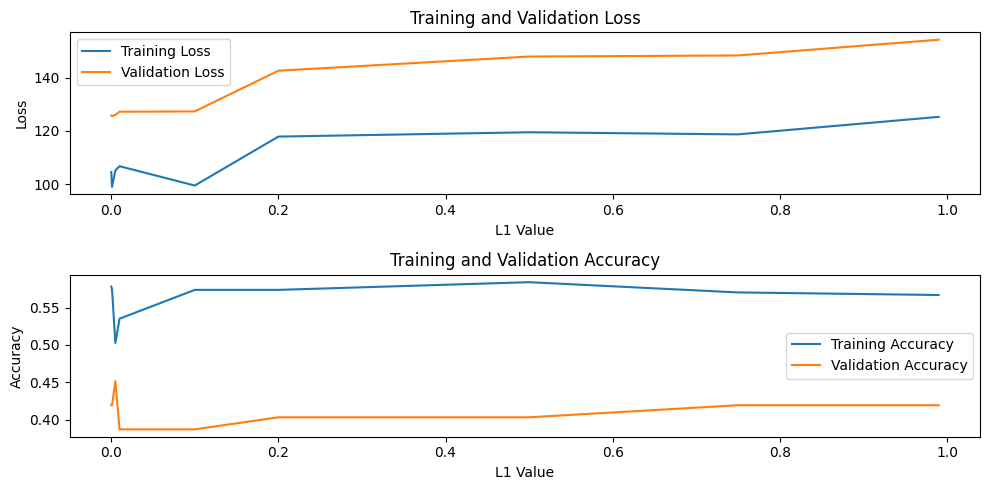

In [9]:
import matplotlib.pyplot as plt

l1 = 0 
train_data = {}
losses = []
val_losses = []
outcome_accuracies = []
val_outcome_accuracies = []
spread_mses = []
val_spread_mses = []

for input in core_stats:
    train_data[input] = x_train[input]
    l1 += x_train[input].shape[1]

l1_vals = [0.0001, 0.001, 0.005, 0.01, 0.1, 0.2, 0.5, 0.75, 0.99]
best_val = 0
best_loss = 1000

for l1_val in l1_vals:
    model = build_lasso_model(train_data, y_train, model_name="core_stats", layers=[l1, l1, l1, l1], activation_function="gelu", show_summary=False, l1_val=l1_val)
    history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=100, validation_split=0.05, verbose=0)
    
    loss = min(history.history['loss'])
    val_loss = min(history.history['val_loss'])
    outcome_accuracy = min(history.history['outcome_accuracy'])
    val_outcome_accuracy = min(history.history['val_outcome_accuracy'])
    spread_mse = min(history.history['spread_mean_squared_error'])
    val_spread_mse = min(history.history['val_spread_mean_squared_error'])
    
    losses.append(loss)
    val_losses.append(val_loss)
    outcome_accuracies.append(outcome_accuracy)
    val_outcome_accuracies.append(val_outcome_accuracy)
    spread_mses.append(spread_mse)
    val_spread_mses.append(val_spread_mse)
    
    print(f"final loss = {loss}, final validation_loss = {val_loss}")
    print(f"final outcome accuracy = {outcome_accuracy}, final validation_accuracy = {val_outcome_accuracy}")
    print(f"final spread mse = {spread_mse}, final validation_mse = {val_spread_mse}")
    print()
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_val = l1_val

print("best l1 val:", best_val)

# Plot the values
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(l1_vals, losses, label='Training Loss')
plt.plot(l1_vals, val_losses, label='Validation Loss')
plt.xlabel('L1 Value')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(l1_vals, outcome_accuracies, label='Training Accuracy')
plt.plot(l1_vals, val_outcome_accuracies, label='Validation Accuracy')
plt.xlabel('L1 Value')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


L1 normalization seems to help but as the value of the l1 norm increases model performance tends to decrease as loss increases and accuracy decreases 

## Feature selection for player_stats
The advanced player stats data we used includes a wide variety of stats for all regular season games in a season. In order to optimize our model's performance, we ran a mutation-free genetic algorithm to iterate through different combinations of player stats.

We assessed the model's performance based on improving spread and outcome accuracy, and provided outputs of the highest performing model features.

In [10]:
def train_input_loop(best_train_data, home_keys, away_keys, lead_val_loss, i):
    print(f"train_input_loop_{i+1}")
    new_btd ={}
    while home_keys != []:
        old_lead_val_accuracy = lead_val_loss
        l1 = 0
        for key in best_train_data.keys():
            l1+=best_train_data[key].shape[1]
        for key_idx in range(len(home_keys)):
            train_data= copy.deepcopy(best_train_data)
            # add stats being tested
            train_data[home_keys[key_idx]] = x_train[home_keys[key_idx]]
            train_data[away_keys[key_idx]] = x_train[away_keys[key_idx]]
      
            
            l1 += x_train[home_keys[key_idx]].shape[1]+ x_train[away_keys[key_idx]].shape[1]
            model = build_lasso_model(train_data, y_train, model_name="core_stats", layers=[l1, l1, l1, l1], activation_function="gelu", show_summary=False, l1_val=0.005)
            history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=150, validation_split = 0.3, verbose = 0)
            cur_val_loss = min(history.history['val_loss'])
            if cur_val_loss < lead_val_loss:
                lead_val_loss = cur_val_loss
                new_btd = copy.deepcopy(train_data)
                print("\n", train_data.keys())
                model.save('efs_model.keras')
                print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
                print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
                print(f"Best mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")
                print()
            else:
                print(cur_val_loss, end =" ")
            l1 = 0
            for key in best_train_data.keys():
                l1+=best_train_data[key].shape[1]
                
    
        if old_lead_val_accuracy != lead_val_loss:
            home_keys_c = home_keys.copy()  # Make a copy to avoid modifying the original
            away_keys_c = away_keys.copy()  # Make a copy to avoid modifying the original
            print("best keys")
            print(new_btd.keys())

            for key in new_btd.keys():
                if key in home_keys_c:
                    home_keys_c.remove(key)
                elif key in away_keys_c:  # Fixing this condition
                    away_keys_c.remove(key)
            
            i = i+1
            return train_input_loop(new_btd, home_keys_c, away_keys_c, lead_val_loss, i)
        else:
            print("best model params above")
            return

In [11]:
train_core= {}
for stat in core_stats:
    train_core[stat] = x_train[stat]

train_input_loop(train_core, home_keys, away_keys, 1000, 0)

train_input_loop_1

 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_Age_input', 'away_Age_input'])
Best loss = 97.0084457397461, Best validation_loss = 126.96905517578125
Best accuracy = 0.7108014225959778, Best validation_accuracy = 0.6341463327407837
Best mse = 96.39227294921875, final validation_mse = 124.64119720458984


 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_G_input', 'away_G_input'])
Best loss = 115.21551513671875, Best validation_loss = 126.39142608642578
Best accuracy = 0.6794425249099731, Best validation_accuracy = 0.6368563771247864
Best mse = 114.18218231201172, final validation_mse = 123.91010284423828

129.26963806152344 
 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_PER_input', 'away_PER_input'])
Best loss = 99.02337646484375, Best validation_loss = 12

### Results

 Our team saw huge improvements for our model with feature selection of player stats. We have achieved 64% accuracy on outcome prediction, and saw a mean squared error of 154 for predicting the spread. 

In [12]:
model = tf.keras.models.load_model('efs_model.keras')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_avg_stats_inp… │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_avg_stats_inp… │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 17)        │        306 │ home_avg_stats_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 17)        │        306 │ away_avg_stats_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_WS_input       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_WS_input       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_DBPM_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_DBPM_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_BLK%_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_BLK%_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 193)       │          0 │ home_team_input[… │
│ (Concatenate)       │                   │            │ away_team_input[… │
│                     │                   │            │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ arena_input[0][0… │
│                     │                   │            │ home_WS_input[0]… │
│                     │                   │            │ away_WS_input[0]… │
│                     │                   │            │ home_DBPM_input[… │
│                     │                   │            │ away_DBPM_input[… │
│                     │                   │            │ home_BLK%_input[… │
│                     │                   │            │ away_BLK%_input[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 565,755 (2.16 MB)

 Trainable params: 188,584 (736.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 377,171 (1.44 MB)

In [16]:
def select_features(train_data):
    train_subset = {}
    features = ['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_PER_input', 'away_PER_input', 'home_WS_input', 'away_WS_input', 'home_AST%_input', 'away_AST%_input', 'home_VORP_input', 'away_VORP_input']
    for key in features:
        train_subset[key]=train_data[key]
    return train_subset

examining model predictions 

In [17]:
x_train_select= select_features(x_train)

In [18]:
#look at spread predictions 
predictions = model.predict(x_train_select)
spread = predictions[0]
putcome = predictions[1]
#outcome
predictions = np.argmax(putcome, axis = 1)
print("accuracy: ", calculate_accuracy(np.argmax(y_train['outcome'],  axis =1), predictions))
plt.hist(np.argmax(putcome,  axis =1), alpha=0.5, label='preds')
observed = np.argmax(y_train['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.savefig('fs_outcome_hist.png')
plt.show()

cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.savefig('fs_outcome_cm.png')
plt.show()
 
#spread 
print("accuracy: ", calculate_accuracy(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int)))
plt.figure(figsize=(8, 6))
plt.hist(spread, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_train['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.savefig('fs_spread_hist.png')
plt.show()
 
cmap = sns.color_palette("Reds", as_cmap=True)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_train['spread'], np.round(spread).astype(int)), cmap=cmap, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('fs_spread_cm.png')
plt.show()

ValueError: Missing data for input "home_DBPM_input". You passed a data dictionary with keys ['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_PER_input', 'away_PER_input', 'home_WS_input', 'away_WS_input', 'home_AST%_input', 'away_AST%_input', 'home_VORP_input', 'away_VORP_input']. Expected the following keys: ['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_WS_input', 'away_WS_input', 'home_DBPM_input', 'away_DBPM_input', 'home_BLK%_input', 'away_BLK%_input']

### Model Experiment 1: Player Stat Selection

In this experiment, we saw amazing initial results for predicting the game outcome for home team win or loss at 74% accuracy, but the model preforms poorly at predicting spread at 31%.

# fine tuning model parameters  

#### Model Experiment 2 : Dropout Rate

In order to normalize our outputs, we experimented with adding multiple layers with a range of dropout rates. We evaluated model preformace with dropout rates of 0.01, 0.05, 0.1, 0.2, and 0.25. We ran through each of these values, and analyzed the results. 

In [ ]:
array = [1, 1, 1, 1, 1]
combinations = generate_combinations(array)
drop_rate = [0.01, 0.05, 0.1, 0.2, 0.25]
best_loss = 1000
params = (0,[])
best_params = (0,[])
plt.figure(figsize=(8, 8))
for val in drop_rate:
    loss_values = []
    for combination in combinations:  
        model = build_model_do(x_train_select, y_train, val, combination, model_name="core_stats", layers=[209, 209, 209, 209], activation_function="gelu", show_summary=False)
        history = model.fit(x=x_train_select, y=y_train, epochs=50, batch_size=150, validation_split = 0.3, verbose = 0)
        params = (val, combination)
        cur_loss = min(history.history['val_loss'])
        loss_values.append(cur_loss)
        if cur_loss<best_loss:
            print("Dropout Rate: ", val, ", layers: ", combination)
            best_loss = cur_loss 
            best_params = params  
            print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
            print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
            print(f"Best mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")
            print()
        else:
            print("Dropout Rate: ", val, ", layers: ", combination, "loss: ",  round(cur_loss, 2), end = " ")
    plt.plot(range(len(combinations)), loss_values, label=f"Dropout Rate: {val}") 
print("\n Best Params: ", best_params)
plt.title('Validation Loss for Different Dropout Rates and Layer Configurations')
plt.xlabel('Combination Index')
plt.ylabel('Validation Loss')
plt.xticks(range(len(combinations)), [str(combination) for combination in combinations], rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('droupout_testing.png')
plt.show()

#### Activation function Experiment
Carrying on from the previous experiment, it was important to establish whether the problem was applying dropout to our model or whether it was the combination of dropout with a specific activation. Our model makes use of **gelu** which we discovered the best performance from earlier tests.

To test this, we made use of the best dropout rate of 0.2. Further, to ensure that our activation function was still the best use with dropout, we cycled through different activation functions to test which gave the best performance. The activation functions being tested are the following: relu, leaky_relu, swish, mish, tanh, gelu, selu. 
*(contributed by: Mervin McDougall)*

In [ ]:
# array = [1, 1, 1, 1, 1]
# combinations = generate_combinations(array)
activation_function = [ 'tanh', 'relu', 'leaky_relu', 'swish', 'mish', 'gelu', 'selu']
best_loss = 1000
params = (0,[])
best_params = (0,[])
plt.figure(figsize=(8, 8))
for af in activation_function:
    loss_values = []
    for combination in combinations:
        model = build_model_do(x_train_select, y_train, val, combination, model_name="core_stats", layers=[209, 209, 209, 209], activation_function=af, show_summary=False)
        history = model.fit(x=x_train_select, y=y_train, epochs=50, batch_size=150, validation_split = 0.3, verbose = 0)
        params = (af, combination)
        cur_loss = min(history.history['val_loss'])
        loss_values.append(cur_loss)
        if cur_loss<best_loss:
            print("Activation Function: ", af, ", layers: ", combination)
            best_loss = cur_loss 
            best_params = params  
            print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
            print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
            print(f"Best mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")
            print()
        else:
            print("Activation Function: ", af, ", layers: ", combination, "loss: ",  round(cur_loss, 2), end = "\n")
    plt.plot(range(len(combinations)), loss_values, label=f"Validation Function: {af}") 
print("\n Best Params: ", best_params)
plt.title('Validation Loss for Different Activation Functions and Layer Configurations')
plt.xlabel('Activation Index')
plt.ylabel('Validation Loss')
plt.xticks(range(len(combinations)), [str(combination) for combination in combinations], rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('activation_function_testing.png')
plt.show()

### Results

We iterated across different l1 configurations, and saw that, at a drop out rate of 0.2 and l1 useage later in the model, we saw our model reduce overfitting and have higher overall performance.

In [ ]:
# Best Params:  (0.2, [0, 0, 0, 0, 1])
# Initialize variables
loss_values = []
best_loss = 1000
best_params = (0, [])

plt.figure(figsize=(10, 6))

for combination in combinations:  
    # Build the model
    model = build_model_bn(x_train_select, y_train, 0.2, [0, 0, 0, 0, 1], combination, "core_stats", [209, 209, 209, 209], "gelu", False)
    history = model.fit(x=x_train_select, y=y_train, epochs=50, batch_size=150, validation_split=0.3, verbose=0)
    
    # Update loss values
    cur_loss = min(history.history['val_loss'])
    loss_values.append(cur_loss)
    
    # Update best parameters
    if cur_loss < best_loss:
        best_loss = cur_loss 
        best_params = combination
        print("\nBest parameters:", best_params)
        print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
        print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
        print(f"Best mse = {min(history.history['spread_mean_squared_error'])}, final validation_mse = {min(history.history['val_spread_mean_squared_error'])}")
        print()
    else:
        print(cur_loss, end = " ")
print("best params: ", best_params)
# Plot the results
sorted_combinations = [x for _, x in sorted(zip(loss_values, combinations))]
sorted_loss_values = sorted(loss_values)

# Plot the results
plt.plot(range(len(sorted_combinations)), sorted_loss_values, marker='o', linestyle='-')
plt.title('Validation Loss for Different Combinations')
plt.xlabel('Combination Index')
plt.ylabel('Validation Loss')
plt.xticks(range(len(sorted_combinations)), [str(combination) for combination in sorted_combinations], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('batch_normalization_testing.png')
plt.show()

### Model Experiment 3: Batch Normalization

We initially believed that batch normailzation would help our model perform better, especially in regards to predicting the spread. The spread value had a high range, with values from negative 40 to postive 40. However, normalization of this output ultimately did not improve performance, even when we ran the model with different l1 configurations and batch normalization at different layers.

In [ ]:
# current best model 
model = build_model_do(x_train_select, y_train, 0.2, [0, 0, 0, 0, 1] , model_name="core_stats", layers=[209, 209, 209, 209], activation_function="gelu", show_summary=False)
history = model.fit(x=x_train_select, y=y_train, epochs=50, batch_size=150, validation_split = 0.3, verbose = 0)
model.save("cb_model.keras")

In [ ]:
#look at spread predictions 
model = tf.keras.models.load_model("cb_model.keras")
predictions = model.predict(x_train_select)
spread = predictions[0]
putcome = predictions[1]
#outcome
predictions = np.argmax(putcome, axis = 1)
print("accuracy: ", calculate_accuracy(np.argmax(y_train['outcome'],  axis =1), predictions))
plt.hist(np.argmax(putcome,  axis =1), alpha=0.5, label='preds')
observed = np.argmax(y_train['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.savefig('cb_outcome_hist.png')
plt.show()

cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.savefig('cb_outcome_cm.png')
plt.show()
 
#spread 
print("accuracy: ", calculate_accuracy(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int)))
plt.figure(figsize=(8, 6))
plt.hist(spread, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_train['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.savefig('cb_spread_hist.png')
plt.show()
 
cmap = sns.color_palette("Reds", as_cmap=True)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_train['spread'], np.round(spread).astype(int)), cmap=cmap, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('cb_spread_cm.png')
plt.show()

## Hyperparameter Grid Search

In [ ]:
def model_hp_testing(x_dict, y_dict, name, spread_loss, outcome_loss, this_optimizer, activation_function, last_act, show_summary = False):
    model_name = name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    concat_input= []
    l1 = 0
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        if input == "home_avg_stats_input":
            # create l1 reg
            home_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation=activation_function,  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(home_avg_stats_input_d )
            l1+=x_dict[input].shape[1]
        elif input == "away_avg_stats_input":
            # create l1 reg
            away_avg_stats_input_d = tf.keras.layers.Dense(x_dict[input].shape[1], activation=activation_function,  kernel_regularizer=tf.keras.regularizers.l1(0.001))(input_dict[input])
            concat_input.append(away_avg_stats_input_d)
            l1+=x_dict[input].shape[1]
 
        else:
            l1+=x_dict[input].shape[1]
            concat_input.append(input_dict[input])
        
    concatenated_inputs = tf.keras.layers.concatenate(concat_input)
    h1 = tf.keras.layers.Dense(l1, activation=activation_function)(concatenated_inputs)
    h2 = tf.keras.layers.Dense(l1, activation=activation_function)(h1)
    h3 = tf.keras.layers.Dense(l1, activation=activation_function)(h2)
    h4 = tf.keras.layers.Dense(l1, activation=activation_function)(h3)
    h5 = tf.keras.layers.Dense(l1, activation=activation_function)(h4)
    h5_d = tf.keras.layers.Dropout(0.2)(h5)
    concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], h5_d, input_dict['away_team_input']])
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(2, activation=last_act, name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':spread_loss , 'outcome':outcome_loss}, optimizer=this_optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), "accuracy"])
    
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

In [ ]:
spread_loss = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError(), 
               tf.keras.losses.Poisson(reduction="sum_over_batch_size"), tf.keras.losses.Poisson(reduction="sum"),
               tf.keras.losses.Huber(delta=0.5),tf.keras.losses.Huber(delta=1.0), tf.keras.losses.Huber(delta=1.5),
               tf.keras.losses.Huber(delta=1.0, reduction = "sum")]

last_layer_list = [tf.keras.activations.softplus, tf.keras.activations.softmax]

# save 3 best models for comparison 
top_models = []
new_best = 1000
params = {}
best_hp_loss = 0
best_hp_val_loss = 0
 
for spread_loss_funct in spread_loss:
    params[spread_loss_funct] = {}
    for last_layer_funct in last_layer_list:
      # Train and evaluate the model with the current set of hyperparameters
            model = model_hp_testing(x_train_select, y_train, "model_name", spread_loss_funct, "mean_squared_error", "Nadam", "gelu", last_layer_funct)
            print(spread_loss_funct, last_layer_funct, end = " ")
            history = model.fit(x_train_select, y_train, epochs=50, batch_size = 150, verbose=False,
            validation_split = 0.3)
            cur_val_loss = min(history.history['val_loss'])
            # Update best parameters
            if cur_val_loss < new_best:
                print(cur_val_loss)
                new_best = cur_val_loss
                params[spread_loss_funct][last_layer_funct] = cur_val_loss
                print("\nBest parameters:", spread_loss_funct, last_layer_funct)
                print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
                print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
                top_models.append(model)
                if len(top_models)>3:
                    top_models = top_models[1:]
                print()
            else:
                print(cur_val_loss, end = " ")
for model in range(len(top_models)):
    top_models[model].save(f"no{len(top_models)-model}_model.keras")

In [ ]:
# graphs of testing results 
# params dict

In [ ]:
#look at spread predictions 
for model in range(len(top_models)):
    model_name = f"no{model+1}_model.keras"
    print(model_name)
    model = tf.keras.models.load_model(model_name)
    predictions = model.predict(x_train_select)
    spread = predictions[0]
    putcome = predictions[1]
    #outcome
    predictions = np.argmax(putcome, axis = 1)
    print("accuracy: ", calculate_accuracy(np.argmax(y_train['outcome'],  axis =1), predictions))
    plt.figure(figsize=(5, 5))
    plt.hist(np.argmax(putcome,  axis =1), alpha=0.5, label='preds')
    observed = np.argmax(y_train['outcome'],  axis =1)
    plt.hist(observed, alpha=0.5, label='obser')
    plt.legend()
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of winner Predicted vs Observed Values')
    plt.savefig(model_name+'outcome_hist.png')
    plt.show()
    plt.figure(figsize=(5, 5))
    cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
    cm.plot()
    plt.savefig(model_name+'outcome_cm.png')
    plt.show()
     
    #spread 
    print("accuracy: ", calculate_accuracy(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int)))
    plt.figure(figsize=(5, 5))
    plt.hist(spread, bins=40, label='Predicted', alpha=0.5)
    plt.hist(y_train['spread'], bins=40, label='Observed', alpha=0.5)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of spread Predicted vs Observed Values')
    plt.legend()
    plt.savefig(model_name+'_spread_hist.png')
    plt.show()
     
    plt.figure(figsize=(8, 8))
    cm_spread = confusion_matrix(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int))
    sns.heatmap(cm_spread, cmap='Reds', annot=True, fmt='d', cbar=False)
    plt.xticks(ticks=np.arange(41) + 0.5, labels=np.arange(-20, 21))
    plt.yticks(ticks=np.arange(41) + 0.5, labels=np.arange(-20, 21))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for Spread')
    plt.savefig(model_name + '_spread_cm.png')
    plt.show()

no_1 model seems to perform the best

In [ ]:
top_models[0].save("best_tuned_model.keras")

# Testing on next season 

In [ ]:
x_test, y_test= pre_process_binary('2017-18',top_n=8, subset = True)
x_test_select= select_features(x_test)

In [ ]:
model = tf.keras.models.load_model("best_tuned_model.keras")
model_name = "best_tuned_model.keras"
predictions = model.predict(x_test_select)
spread = predictions[0]
putcome = predictions[1]
#outcome
predictions = np.argmax(putcome, axis = 1)
print("accuracy: ", calculate_accuracy(np.argmax(y_train['outcome'],  axis =1), predictions))
plt.hist(np.argmax(putcome,  axis =1), alpha=0.5, label='preds')
observed = np.argmax(y_train['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.savefig(model_name+'outcome_hist.png')
plt.show()

cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.savefig(model_name+'outcome_cm.png')
plt.show()
 
#spread 
print("accuracy: ", calculate_accuracy(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int)))
plt.figure(figsize=(8, 6))
plt.hist(spread, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_train['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.savefig(model_name+'_spread_hist.png')
plt.show()
 
plt.figure(figsize=(8, 8))
cm_spread = confusion_matrix(np.clip(y_train['spread'], -20, 20), np.round(spread).astype(int))
sns.heatmap(cm_spread, cmap='Reds', annot=True, fmt='d', cbar=False)
plt.xticks(ticks=np.arange(41) + 0.5, labels=np.arange(-20, 21))
plt.yticks(ticks=np.arange(41) + 0.5, labels=np.arange(-20, 21))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Spread')
plt.savefig(model_name + '_spread_cm.png')
plt.show()

In [ ]:
print(model_name)

In [ ]:
# model evaluation data 
seasons = ['2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22'] 
results ={}
for train_season in seasons:
    results[train_season] = {}
    print('\n', train_season)
    x_train, y_train= pre_process_binary(train_season,top_n=8, subset = True)
    x_train = select_features(x_train)
    for test_season in seasons:
        results[train_season][test_season] = {}
        print('\n', test_season)
        x_test, y_test= pre_process_binary(test_season, top_n=8, subset = True)
        x_test = select_features(x_test)
        model = model_hp_testing(x_train, y_train, "model_name", tf.keras.losses.Huber(delta=0.5), "mean_squared_error", "Nadam", "gelu", tf.keras.activations.softplus)
        model.fit(x_train, y_train)
        predictions = model.predict(x_test, verbose = 0)
        spread = predictions[0]
        outcome = predictions[1]
        results[train_season][test_season]['outcomepa'] = (np.argmax(outcome, axis = 1), np.argmax(y_test['outcome'], axis = 1))
        results[train_season][test_season]['spreadpa'] = (np.round(spread).astype(int), y_test['spread'])
        print(train_season, " ",  test_season) 

In [ ]:
# your plotting code 
# results 
# format:
# train_season test_season outcomepa prediction, actual 
# format train_season test_season spreadpa prediction, actual 